**Instructions to run code**

This is a colab notebook and thus requires some specific steps to run.

1.) Upload the csv from this dataset (https://www.kaggle.com/datasets/novanglus/music-lyrics-by-genre) to your google drive.

2.) Mount the drive and move this csv to the local colab directory. I show this in some of the code below.

3.) The rest of the code should run smoothly. We recommend using a GPU or you may have memory issues or it may run extremely slowly. When you get to the WandB section at the end you will need to and generate an API key from their website.

In [1]:
#Importing libraries

import numpy as np 
import pandas as pd
import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import nltk
import math
nltk.download('stopwords')

from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing #binarizing the labels

import time 
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#GPU type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 16 23:23:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#Check available RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
#Confirm that GPU is available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [7]:
#Mount Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [8]:
 #Move File from Drive to Colab
!cp "/content/gdrive/MyDrive/NLP_Project_Data/df_lyrics.csv" /content  

In [9]:
df = pd.read_csv('df_lyrics.csv')[['Lyrics', 'Genre']]

#df.columns = ['TEXT_COLUMN_NAME', 'LABEL_COLUMN_NAME']
df.head()

,Lyrics,Genre
0,"Oh, baby, baby Oh, baby, baby Oh, baby, baby...",Pop
1,"Baby, can't you see I'm calling? A guy like y...",Pop
2,You wanna? You wanna? You want a hot body? Y...,Pop
3,"Mmm, yeah Yeah, yeah, yeah, yeah, yeah, yeah ...",Pop
4,"La, la, la, la, la-la, la, la La, la, la, la,...",Pop


In [10]:
# Here we build a custom class that contains a variety of preprocessing methods for our data

import re
import nltk
from nltk.stem import PorterStemmer 
stopWords = set(stopwords.words('english')) 


class PreProcess():
  """
methods: decontraction, removing punctuations, lowercasing, 
removing non-alphanumeric characters, stemming
  """

  def filterpun(self, text):

    replace_by_space = re.compile('[<!./{}\[\]\|@,;%#+_`]')
    filtered = replace_by_space.sub('', text)
    filtered = filtered.replace("'", "")
    filtered = filtered.replace('"', "")
    filtered = filtered.strip()
    filtered = filtered.replace("\n"," ")
    return filtered


  def lowercasing(self, text):
    return text.lower()


  def removespecial(self, text):
    return re.sub(r'\W+', ' ', text)


  def stemming(self, sentence):
    porter_stemmer = PorterStemmer()
    words = sentence.split()
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)


  def removeStop(self, text):

    tokens = []

    for token in text.split():

      if token not in stopWords and token != '':

        tokens.append(token)

    return " ".join(tokens)


#Initialize class
preprocess = PreProcess()

#function for applying all preprocessing how we want
def preprocess_text(text, removeStopWords = False):
    text = preprocess.filterpun(text)
    text = preprocess.lowercasing(text)
    #text = preprocess.removespecial(text)
    #text = preprocess.stemming(text) #stemming lowers the accuracy too bad.
    text = " ".join(text.split()[:-1])
    
    if removeStopWords:
      text = preprocess.removeStop(text)

    return text

df['Lyrics'] = df['Lyrics'].apply(preprocess_text)

In [11]:
df['Lyrics'][2000]

'you used to be my closest ally (uh-huh) in this cold cold world of deception and lies oh we would defend and protect one another (one another) now i cant tell if were enemies or lovers so whos gonna rescue us from ourselves? when we gonna wake up baby? its time for lovin when we gonna wake up my baby? before its too late oh baby where did we go wrong baby? (uh-huh) did this cold cold world turn us into stone? well now all i battle is your ego and your pride its ticking like a time bomb ready to ignite hurtin me to fight so whos gonna rescue us from ourselves? when we gonna wake up baby? its time for lovin when we gonna wake up my baby? before its too late when we gonna wake up baby? its time for lovin when we gonna wake up my baby? before its too late when the smoke clears what will be left for us but tears and pain? why must we argue over the same things just to make up and go back again? its never too late it isnt too long cant get it right when no one thinks theyre wrong gotta get 

In [12]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [13]:
#Factorize our labels

le = preprocessing.LabelEncoder()
le.fit(df.Genre)
unique_genres = le.classes_
print(unique_genres)
num_genres = len(unique_genres)
le.transform(df.Genre)

mlb = preprocessing.MultiLabelBinarizer()
labels = mlb.fit_transform(df[['Genre']].values)
labels

['Country' 'Pop' 'Rap' 'Rock']


array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [14]:
#Create train, test, and validation sets

TEST_SIZE = 0.2
x, y = list(df['Lyrics']), labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = TEST_SIZE, stratify=y)
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5)

print(f'Train Size: {len(x_train)}')
print(f'Test Size: {len(x_test)}')
#print(f'Test Size: {len(x_val)}')

Train Size: 64228
Test Size: 16057


In [15]:
y_test

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

In [16]:
#This is a custom class for building the vocab, we decided not to use 
#it and instead use tortchtext method for vocabulary construction

class Vocab():
    
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.build_vocab()
        
    def build_vocab(self):
        for sent in self.sentences:
            #self.vocab.update(sent.split(' '))
            self.vocab.update(tokenizer(sent))
        
        self.vocab = sorted(self.vocab)
        self.word2idx['<pad>'] = 0
        
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # 0 is the pad
            
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
            
    def __len__(self):
        return len(self.vocab)
            
my_vocab = Vocab(x_train)

In [17]:
print(len(my_vocab)) #with tokenizer

141328


In [18]:
#Here we construct the vocab using torchtext. The yield_tokens method 
#yields tokens instead of returning them so it works with an iterator

from torchtext.vocab import build_vocab_from_iterator

MIN_FREQ = 5

def yield_tokens(lyrics):

  for lyric in lyrics:

    yield tokenizer(lyric)

vocab = build_vocab_from_iterator(yield_tokens(x_train), specials=["<unk>"], min_freq = MIN_FREQ)
vocab.set_default_index(vocab["<unk>"])

In [19]:
print(len(vocab)) #with tokenizer
vocab([')', 'hello', '<unk>', 'example', '?', 'cant', 'cannot', 'gonna', '*'])

43155


[12, 803, 0, 5060, 21, 60, 799, 90, 3336]

In [20]:
#Convert tokens to indices of tokens in vocab

index_train = []

for lyrics in x_train:

  indices = vocab(tokenizer(lyrics))
  index_train.append(indices)

index_test = []

for lyrics in x_test:

  indices = [vocab([token])[0] for token in tokenizer(lyrics)]
  index_test.append(indices)

In [21]:
print(len(index_train))
print(len(index_test))

64228
16057


Max:  13123
Min:  0


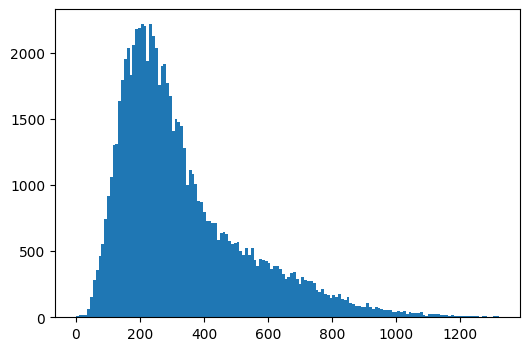

In [23]:
#Visualize lyric lengths to determine good cutoff for padding

lyricSize = []
for lyrics in index_train + index_test:
  
  lyricSize.append(len(lyrics))

print('Max: ', max(lyricSize))
print('Min: ', min(lyricSize))
lyricSize1 = sorted(lyricSize)[:math.floor(len(lyricSize)*0.998)]

fig, ax = plt.subplots(figsize =(6, 4))
ax.hist(lyricSize1, 150)
 
# Show plot
plt.show()

In [24]:
#Function that adds padding of 0s to all the lyrics

def addPadding(lyrics, max_len):

    features = np.zeros((len(lyrics), max_len), dtype=int)

    for i, lyric in enumerate(lyrics):

      if len(lyric) > max_len:
          features[i, :] = lyric[:max_len]
        
      else:
        features[i, :len(lyric)] = lyric
        
    return features

In [25]:
maxWords = 950
index_train_pad = addPadding(index_train, maxWords)
index_test_pad = addPadding(index_test, maxWords)
index_test_pad

array([[    6, 38472,    92, ...,     0,     0,     0],
       [    2,   237,    15, ...,     0,     0,     0],
       [   13,    64,  5512, ...,     0,     0,     0],
       ...,
       [   61,    50,   851, ...,     0,     0,     0],
       [ 4810,   180,    97, ...,     0,     0,     0],
       [   40,    40,     2, ...,     0,     0,     0]])

In [26]:
#Convert input data and labels to tensors and then load into DataLoaders

batchSize = 40

data_train = TensorDataset(torch.from_numpy(index_train_pad).to(device), torch.from_numpy(y_train).to(device))
data_val = TensorDataset(torch.from_numpy(index_test_pad).to(device), torch.from_numpy(y_test).to(device))

train_loader = DataLoader(data_train, shuffle=True, batch_size=batchSize, drop_last=True)
val_loader = DataLoader(data_val, shuffle=True, batch_size=batchSize, drop_last=True)

In [27]:
#LSTM Network
class LSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_size, output_size, nLayers, bidirectional = False):
        super(LSTM, self).__init__()
        self.batch = batch_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size
        
  
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.dropout = nn.Dropout(p=0.5)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_units, num_layers= nLayers, bidirectional = bidirectional)

        if bidirectional:

          self.fc = nn.Linear(2*self.hidden_units, self.output_size)
          self.nLayers = 2*nLayers

        else:

          self.fc = nn.Linear(self.hidden_units, self.output_size)
          self.nLayers = nLayers
        
    def initialize_hidden_state(self, device):

        h_0 = torch.randn(self.nLayers, self.batch, self.hidden_units).to(device)
        c_0 = torch.randn(self.nLayers, self.batch, self.hidden_units).to(device)

        #h_0 = torch.zeros((self.nLayers, self.batch, self.hidden_units)).to(device)
        #c_0 = torch.zeros((self.nLayers, self.batch, self.hidden_units)).to(device)
        return h_0, c_0
    
    def forward(self, x):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device=x.device)
        output, self.hidden = self.lstm(x, self.hidden)
        out = output[-1, :, :]
        #out = self.dropout(out) #L2 reg does much better job than dropout to control overfitting here 
        out = self.fc(out)
        out = nn.functional.softmax(out, dim=1)
        
        return out, self.hidden
    

In [28]:
#Instantiating model, loss function, optimizer

vocab_size = len(vocab)
target_size = 4

model_lstm = LSTM(vocab_size, embedding_dim = 150, hidden_units = 150,
                  batch_size = batchSize, output_size = target_size, nLayers = 1, bidirectional = False)
model_lstm.to(device)
print(model_lstm)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=2e-3, weight_decay=5e-8)
#optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)



LSTM(
  (embedding): Embedding(43155, 150)
  (lstm): LSTM(150, 150)
  (fc): Linear(in_features=150, out_features=4, bias=True)
)


In [29]:
#Training

num_epochs = 20
 
train_loss_list = []
val_loss_list = []
val_acc_list = []
epoch_ct = 0

for epoch in range(num_epochs):
    
    epoch_ct += 1
    print("Epoch: {:.3f}".format(epoch_ct))
    
    model_lstm.train()
    losses_train = []
    
    for inp, ground_truth in tqdm(train_loader):

        predictions, _ = model_lstm(inp.permute(1, 0).to(device))
      
        truth = torch.max(ground_truth, 1)[1]
        loss = loss_fn(predictions, truth) ## Calculate Loss
        losses_train.append(loss.item())
        
        optimizer_lstm.zero_grad()
        loss.backward()
        optimizer_lstm.step()


    model_lstm.eval()
    train_loss = torch.tensor(losses_train).mean()
    print("Train Loss : {:.3f}".format(train_loss))
    train_loss_list.append(train_loss)

    with torch.no_grad():

      losses_val = []

      Y_truth, Y_preds = [],[]

      for X, Y in val_loader:

          preds, _ = model_lstm(X.permute(1, 0).to(device))
          truth = torch.max(Y, 1)[1]

          loss = loss_fn(preds, truth)
          losses_val.append(loss.item())

          Y_truth.append(truth)
          Y_preds.append(preds.argmax(dim=-1))

    val_loss = torch.tensor(losses_val).mean()
    print("Validation Loss : {:.3f}".format(val_loss))
    val_loss_list.append(val_loss)

    Y_truth = torch.cat(Y_truth)
    Y_preds = torch.cat(Y_preds)
    acc_score = accuracy_score(Y_truth.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())
    val_acc_list.append(acc_score)

    print("Validation Acc  : {:.3f}".format(acc_score))

Epoch: 1.000


100%|██████████| 1605/1605 [01:59<00:00, 13.45it/s]


Train Loss : 1.242
Validation Loss : 1.170
Validation Acc  : 0.568
Epoch: 2.000


100%|██████████| 1605/1605 [01:59<00:00, 13.40it/s]


Train Loss : 1.153
Validation Loss : 1.153
Validation Acc  : 0.576
Epoch: 3.000


100%|██████████| 1605/1605 [02:00<00:00, 13.37it/s]


Train Loss : 1.122
Validation Loss : 1.128
Validation Acc  : 0.609
Epoch: 4.000


100%|██████████| 1605/1605 [01:59<00:00, 13.40it/s]


Train Loss : 1.093
Validation Loss : 1.109
Validation Acc  : 0.626
Epoch: 5.000


100%|██████████| 1605/1605 [01:59<00:00, 13.39it/s]


Train Loss : 1.064
Validation Loss : 1.088
Validation Acc  : 0.649
Epoch: 6.000


100%|██████████| 1605/1605 [02:00<00:00, 13.33it/s]


Train Loss : 1.044
Validation Loss : 1.080
Validation Acc  : 0.656
Epoch: 7.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 1.028
Validation Loss : 1.095
Validation Acc  : 0.643
Epoch: 8.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 1.013
Validation Loss : 1.076
Validation Acc  : 0.659
Epoch: 9.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.998
Validation Loss : 1.071
Validation Acc  : 0.666
Epoch: 10.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.989
Validation Loss : 1.075
Validation Acc  : 0.660
Epoch: 11.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.980
Validation Loss : 1.073
Validation Acc  : 0.663
Epoch: 12.000


100%|██████████| 1605/1605 [02:00<00:00, 13.37it/s]


Train Loss : 0.968
Validation Loss : 1.071
Validation Acc  : 0.665
Epoch: 13.000


100%|██████████| 1605/1605 [02:00<00:00, 13.37it/s]


Train Loss : 0.959
Validation Loss : 1.061
Validation Acc  : 0.676
Epoch: 14.000


100%|██████████| 1605/1605 [02:00<00:00, 13.37it/s]


Train Loss : 0.950
Validation Loss : 1.064
Validation Acc  : 0.672
Epoch: 15.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.946
Validation Loss : 1.061
Validation Acc  : 0.676
Epoch: 16.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.943
Validation Loss : 1.067
Validation Acc  : 0.671
Epoch: 17.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.936
Validation Loss : 1.062
Validation Acc  : 0.677
Epoch: 18.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.930
Validation Loss : 1.067
Validation Acc  : 0.671
Epoch: 19.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.926
Validation Loss : 1.062
Validation Acc  : 0.677
Epoch: 20.000


100%|██████████| 1605/1605 [01:59<00:00, 13.38it/s]


Train Loss : 0.920
Validation Loss : 1.065
Validation Acc  : 0.673


In [32]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

labels = Y_truth.detach().cpu().numpy()
predictions = Y_preds.detach().cpu().numpy()

precision, recall, f1, _ = precision_recall_fscore_support(labels,
                                                           predictions,
                                                           average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 score: {f1:.4f}')

Precision: 0.6766
Recall: 0.6740
F1 score: 0.6744


In [36]:
class GRU(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_size, output_size):
        super(GRU, self).__init__()
        self.batch = batch_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size
  
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
        
    def initialize_hidden_state(self, device):

        return torch.randn((1, self.batch, self.hidden_units)).to(device)
    
    def forward(self, x):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(x.device)
        output, self.hidden = self.gru(x, self.hidden)
        out = output[-1, :, :]
        #out = self.dropout(out)
        out = self.fc(out)
        out = nn.functional.softmax(out, dim=1)
        
        return out, self.hidden

In [54]:
class RNN(nn.Module):
  
  def __init__(self, vocab_size, embedding_dim, hidden_units, batch_size, output_size):
      super(RNN, self).__init__()
      self.batch = batch_size
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.hidden_units = hidden_units
      self.output_size = output_size

      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.rnn = nn.RNN(self.embedding_dim, self.hidden_units)
      self.fc = nn.Linear(self.hidden_units, self.output_size)
      
  def initialize_hidden_state(self, device):
      return torch.randn((1, self.batch, self.hidden_units)).to(device)
  
  def forward(self, x):
      x = self.embedding(x)
      self.hidden = self.initialize_hidden_state(device=x.device)
      output, self.hidden = self.rnn(x, self.hidden)
      out = output[-1, :, :]
      out = self.fc(out)
      out = nn.functional.softmax(out, dim=1)
      
      return out, self.hidden

In [34]:
!pip install wandb -Uq

In [35]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Here I use Wandb to keep track of all my runs and do some hyperparameter tuning by playing around with the config.

In [55]:
config = dict(
    epochs=20,
    embed_dim = 100,
    hidden_dim = 100,
    batch_size = 40,
    learning_rate = 2e-3,
    numLayers = 1,
    weight_decay=8e-8,
    bi = False,
    min_freq = MIN_FREQ,
    test_size = TEST_SIZE)

In [56]:
def make_loader(dataset, batch_size):

    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         drop_last=True)
    return loader

In [58]:
def make(config):
    # Make the data
    train_loader = make_loader(data_train, batch_size=config.batch_size)
    test_loader = make_loader(data_val, batch_size=config.batch_size)

    # Make the model
   # model = GRU(vocab_size, embedding_dim = config.embed_dim,
   #             hidden_units = config.hidden_dim, batch_size = config.batch_size, output_size = target_size)

    #model = LSTM(vocab_size, embedding_dim = config.embed_dim, hidden_units = config.hidden_dim,
    #              batch_size = config.batch_size, output_size = target_size, 
    #             nLayers = config.numLayers, bidirectional = config.bi).to(device)
    model = RNN(vocab_size, embedding_dim = config.embed_dim,
                    hidden_units = config.hidden_dim, 
                    batch_size = config.batch_size, output_size = target_size)
    
    model.to(device)

    

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    
    return model, train_loader, test_loader, criterion, optimizer

In [42]:
truthG = 0
predG = 0

In [59]:
def train(model, loader, criterion, optimizer, config, loader_v):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    epoch_ct = 0

    for epoch in tqdm(range(config.epochs)):

      epoch_ct += 1

      print("Epoch: {:.3f}".format(epoch_ct))
      model.train()
      losses_train = []
      
      for inp, ground_truth in loader:
        
        predictions, _ = model(inp.permute(1, 0).to(device))
        
      
        truth = torch.max(ground_truth, 1)[1]
        loss = criterion(predictions, truth) ## Calculate Loss
        losses_train.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      model.eval()
      train_loss = torch.tensor(losses_train).mean()
      print("Train Loss : {:.3f}".format(train_loss))

      with torch.no_grad():

        losses_val = []

        Y_truth, Y_preds = [],[]

        for X, Y in loader_v:

            preds, _ = model(X.permute(1, 0).to(device))
            truth = torch.max(Y, 1)[1]

            loss = criterion(preds, truth)
            losses_val.append(loss.item())

            Y_truth.append(truth)
            Y_preds.append(preds.argmax(dim=-1))

      val_loss = torch.tensor(losses_val).mean()
      print("Validation Loss : {:.3f}".format(val_loss))

      Y_truth = torch.cat(Y_truth)
      Y_preds = torch.cat(Y_preds)

      truthG = Y_truth.detach().cpu().numpy()
      predG = Y_preds.detach().cpu().numpy()
      acc_val = accuracy_score(truthG, predG)

      print("Validation Acc  : {:.3f}".format(acc_val))

      train_log(train_loss, val_loss, acc_val, epoch)



def train_log(train_loss, val_loss, acc_val, epoch_ct):
    # Where the magic happens
    wandb.log({"loss": train_loss, "val_loss": val_loss, "val_acc": acc_val}, step=epoch_ct)

In [60]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="LSTM1", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config, loader_v = test_loader)

      # and test its final performance
      #test(model, test_loader)

    return model

In [61]:
model = model_pipeline(config)

RNN(
  (embedding): Embedding(43155, 100)
  (rnn): RNN(100, 100)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1.000
test
Train Loss : 1.381


  5%|▌         | 1/20 [00:20<06:27, 20.42s/it]

Validation Loss : 1.377
Validation Acc  : 0.283
Epoch: 2.000
test
Train Loss : 1.377


 10%|█         | 2/20 [00:40<06:04, 20.26s/it]

Validation Loss : 1.376
Validation Acc  : 0.286
Epoch: 3.000
test
Train Loss : 1.377


 15%|█▌        | 3/20 [01:00<05:39, 19.94s/it]

Validation Loss : 1.379
Validation Acc  : 0.283
Epoch: 4.000
test
Train Loss : 1.376


 20%|██        | 4/20 [01:19<05:15, 19.70s/it]

Validation Loss : 1.375
Validation Acc  : 0.286
Epoch: 5.000
test
Train Loss : 1.377


 25%|██▌       | 5/20 [01:39<04:55, 19.67s/it]

Validation Loss : 1.382
Validation Acc  : 0.286
Epoch: 6.000
test
Train Loss : 1.376


 30%|███       | 6/20 [01:58<04:34, 19.58s/it]

Validation Loss : 1.377
Validation Acc  : 0.283
Epoch: 7.000
test
Train Loss : 1.377


 35%|███▌      | 7/20 [02:18<04:14, 19.59s/it]

Validation Loss : 1.377
Validation Acc  : 0.286
Epoch: 8.000
test
Train Loss : 1.379


 40%|████      | 8/20 [02:37<03:53, 19.49s/it]

Validation Loss : 1.384
Validation Acc  : 0.283
Epoch: 9.000
test
Train Loss : 1.377


 45%|████▌     | 9/20 [02:56<03:34, 19.53s/it]

Validation Loss : 1.377
Validation Acc  : 0.283
Epoch: 10.000
test
Train Loss : 1.377


 50%|█████     | 10/20 [03:16<03:14, 19.42s/it]

Validation Loss : 1.380
Validation Acc  : 0.239
Epoch: 11.000
test
Train Loss : 1.377


 55%|█████▌    | 11/20 [03:35<02:54, 19.44s/it]

Validation Loss : 1.379
Validation Acc  : 0.286
Epoch: 12.000
test
Train Loss : 1.376


 60%|██████    | 12/20 [03:54<02:35, 19.38s/it]

Validation Loss : 1.374
Validation Acc  : 0.286
Epoch: 13.000
test
Train Loss : 1.376


 65%|██████▌   | 13/20 [04:14<02:16, 19.43s/it]

Validation Loss : 1.374
Validation Acc  : 0.283
Epoch: 14.000
test
Train Loss : 1.376


 70%|███████   | 14/20 [04:33<01:56, 19.37s/it]

Validation Loss : 1.374
Validation Acc  : 0.286
Epoch: 15.000
test
Train Loss : 1.376


 75%|███████▌  | 15/20 [04:53<01:37, 19.43s/it]

Validation Loss : 1.373
Validation Acc  : 0.286
Epoch: 16.000
test
Train Loss : 1.377


 80%|████████  | 16/20 [05:12<01:17, 19.37s/it]

Validation Loss : 1.376
Validation Acc  : 0.283
Epoch: 17.000
test
Train Loss : 1.377


 85%|████████▌ | 17/20 [05:32<00:58, 19.44s/it]

Validation Loss : 1.376
Validation Acc  : 0.286
Epoch: 18.000
test
Train Loss : 1.377


 90%|█████████ | 18/20 [05:51<00:38, 19.31s/it]

Validation Loss : 1.383
Validation Acc  : 0.286
Epoch: 19.000
test
Train Loss : 1.379


 95%|█████████▌| 19/20 [06:10<00:19, 19.35s/it]

Validation Loss : 1.381
Validation Acc  : 0.277
Epoch: 20.000
test
Train Loss : 1.380


100%|██████████| 20/20 [06:29<00:00, 19.49s/it]

Validation Loss : 1.381
Validation Acc  : 0.285


loss,█▃▂▁▂▁▃▆▂▃▂▂▁▁▁▂▃▂▆▇
val_acc,████████▇▁████████▇█
val_loss,▃▃▅▂▇▄▃█▃▆▅▂▂▁▁▂▃█▆▆
loss,1.38013
val_acc,0.28529
val_loss,1.38103
